**In this notebook, we will implement a Neural Network using fully connected layers. Such a neural network is also known as standard neural network. Here, we will get down to the basics of Neural Network implementation inspired by Andrew Ng's Deep Learning Specialization on Coursera. **

**The purpose of this notebook is only to revisit the basics and we are not looking to have a highly efficient model here. But we will try our best.
You can find a better solution here: https://www.kaggle.com/sarvajna/dogs-vs-cats-keras-solution**

**You will see later on that this model doesn't perform so well. This showcases the fact that Standard Neural Nets are not well suited for classifying images. Convolutional Neural Nets perform better**

**Just a headsup, we will be printing the dimensions of the matrices in many places to make sure we have got it right.**

**Perform the necessary imports**

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy
import re
import os
import cv2
import math

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**Self-explanatory globals**

In [2]:
image_width = 150
image_height = 150
number_of_color_channels = 3 #RGB
data = "../input/train/"

**We will not use "../input/test/" in this notebook as we are not intending to submit. We will split the entire training set into train, dev(cross-validation) and test  sets later**

In [3]:
data_set = [data+idx for idx in os.listdir(path=data)]

**Helper functions to sort the image files based on the numeric value in each file name.**

In [4]:
def atoi(text):
    if text.isdigit() == True: #text contains digits only
        return int(text)
    else:
        return text
    
def natural_keys(text):
    return [atoi(idx) for idx in re.split(pattern='(\d+)', string=text)]

In [5]:
data_set.sort(key=natural_keys)
#data_set = data_set[0:5000] + data_set[12500:17500]
data_set = data_set[0:2500] + data_set[12500:15000]
#data_set = data_set[0:3000] + data_set[12500:15500]

**Function to represent images as real numbers **

In [6]:
def prepare_data(list_of_images):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    x = np.zeros(shape=(len(list_of_images), image_width, image_height, number_of_color_channels))
    y = np.zeros(shape=(1, len(list_of_images)))
    
    for (index, image) in enumerate(list_of_images):
        #read_image = np.array(ndimage.imread(image, flatten=False)) #deprecated in SciPy 1.0.0
        #my_image = scipy.misc.imresize(read_image, size=(150,150)) #deprecated in Scipy 1.0.0, will be removed in SciPy 1.2.0
        read_image = np.array(cv2.imread(image))
        my_image = cv2.resize(src=read_image, dsize=(image_width, image_height))
        x[index] = my_image
    
    for (index, image) in enumerate(list_of_images):
        if 'dog' in image:
            y[:, index] = 1
        elif 'cat' in image:
            y[:, index] = 0
            
    return x, y

In [7]:
x_all, y_all = prepare_data(data_set)

**Helper function to check out the properties of numpy arrays. We will be using this to validate dimensions of matrices throughout the rest of the code.**

In [8]:
def numpy_array_properties(array):
    print("type:{}, shape:{}, dimensions:{}, size:{}, datatype:{}".format(type(array), array.shape, array.ndim, array.size, array.dtype))

In [9]:
numpy_array_properties(x_all)
numpy_array_properties(y_all)

type:<class 'numpy.ndarray'>, shape:(5000, 150, 150, 3), dimensions:4, size:337500000, datatype:float64
type:<class 'numpy.ndarray'>, shape:(1, 5000), dimensions:2, size:5000, datatype:float64


A side-by-side plot of:

**Image on the left**: Read and Resized Image 

**Image on the right**: Original Image

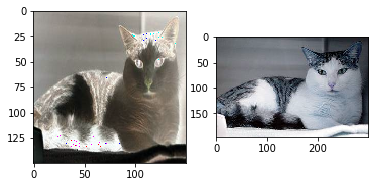

In [10]:
fig = plt.figure()
img1 = fig.add_subplot(1,2,1) #1 row, 2 coulmns, image fills the 1st column
img1.imshow(x_all[50])
img2 = fig.add_subplot(1,2,2) #1 row, 2 columns, image fills the 2nd column
img2.imshow(np.array(cv2.imread(data_set[50])))

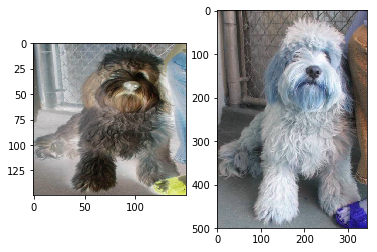

In [11]:
fig = plt.figure()
img1 = fig.add_subplot(1,2,1) #1 row, 2 coulmns, image fills the 1st column
img1.imshow(x_all[4305]) 
img2 = fig.add_subplot(1,2,2)
img2.imshow(np.array(cv2.imread(data_set[4305]))) #1 row, 2 columns, image fills the 2nd column

**Reshape the input x_train_dev to a vector. i.e., currently x_train_dev is of shape (number_of_examples, image_width, image_height, number_of_color_channels), **

**we now want it to be of shape (image_width\*image_height\*number_of_color_channels, number_of_examples)**

In [12]:
x_all_flatten = x_all.reshape(x_all.shape[0], -1).T

**Normalize the flattened array by 255 since RGB values are between 0 and 255**

In [13]:
x_all_flatten_normalized = x_all_flatten/255.

In [14]:
numpy_array_properties(x_all_flatten_normalized)

type:<class 'numpy.ndarray'>, shape:(67500, 5000), dimensions:2, size:337500000, datatype:float64


**Let us now shuffle the data set randomly. We also have to make sure that x(input in general sense) and y(output labels in general sense) remain in sync during the shuffling. **

**np.random.permutation(..) helps us with that.**

In [15]:
def synch_shuffle_data(x, y):
    np.random.seed(1)
    permutation = list(np.random.permutation(x.shape[1]))
    x_shuffled = x[:, permutation]
    y_shuffled = y[:, permutation]
    return x_shuffled, y_shuffled

In [16]:
x_all_flatten_normalized_shuffled, y_all_shuffled = synch_shuffle_data(x_all_flatten_normalized, y_all)

In [17]:
numpy_array_properties(x_all_flatten_normalized_shuffled)
numpy_array_properties(y_all_shuffled)

type:<class 'numpy.ndarray'>, shape:(67500, 5000), dimensions:2, size:337500000, datatype:float64
type:<class 'numpy.ndarray'>, shape:(1, 5000), dimensions:2, size:5000, datatype:float64


**Split the data into  60% as train data, 20% as dev_set and the rest 20% as test set. Instead, sklearn.model_selection.train_test_split can be used**

In [18]:
x_train = x_all_flatten_normalized_shuffled[:, 0:3000]
x_dev = x_all_flatten_normalized_shuffled[:, 3000:4000]
x_test = x_all_flatten_normalized_shuffled[:, 4000:5000]
y_train = y_all_shuffled[:, 0:3000]
y_dev = y_all_shuffled[:, 3000:4000]
y_test = y_all_shuffled[:, 4000:5000]

In [19]:
numpy_array_properties(x_train)
numpy_array_properties(y_train)
numpy_array_properties(x_dev)
numpy_array_properties(y_dev)
numpy_array_properties(x_test)
numpy_array_properties(y_test)

type:<class 'numpy.ndarray'>, shape:(67500, 3000), dimensions:2, size:202500000, datatype:float64
type:<class 'numpy.ndarray'>, shape:(1, 3000), dimensions:2, size:3000, datatype:float64
type:<class 'numpy.ndarray'>, shape:(67500, 1000), dimensions:2, size:67500000, datatype:float64
type:<class 'numpy.ndarray'>, shape:(1, 1000), dimensions:2, size:1000, datatype:float64
type:<class 'numpy.ndarray'>, shape:(67500, 1000), dimensions:2, size:67500000, datatype:float64
type:<class 'numpy.ndarray'>, shape:(1, 1000), dimensions:2, size:1000, datatype:float64


In [20]:
print(x_train)
print("*"*100)
print(y_train)
print("*"*100)
print(x_dev)
print("*"*100)
print(y_dev)
print("*"*100)
print(x_test)
print("*"*100)
print(y_test)

[[0.4        0.38039216 0.19607843 ... 0.71764706 1.         0.74509804]
 [0.41568627 0.41176471 0.24313725 ... 0.63137255 1.         0.63529412]
 [0.37647059 0.45490196 0.31372549 ... 0.65098039 0.96470588 0.75294118]
 ...
 [0.48627451 0.67843137 0.06666667 ... 0.15294118 0.34509804 0.25882353]
 [0.47843137 0.65490196 0.12156863 ... 0.38823529 0.30980392 0.24705882]
 [0.43529412 0.65882353 0.19607843 ... 0.26666667 0.39215686 0.28235294]]
****************************************************************************************************
[[1. 1. 1. ... 1. 0. 0.]]
****************************************************************************************************
[[0.6        0.19215686 0.         ... 0.28235294 0.44705882 0.43529412]
 [0.60784314 0.26666667 0.01176471 ... 0.29411765 0.41568627 0.62352941]
 [0.60784314 0.25490196 0.03137255 ... 0.30980392 0.35686275 0.50980392]
 ...
 [0.99607843 0.33333333 0.0745098  ... 0.         0.0627451  0.69411765]
 [0.99607843 0.39607843 0.09803

**Before proceeding, plot the images and verify the labels(to validate shuffling has happened in synch between x and y, also for fun ;))**

In [21]:
def recreate_image_from_numpy_array(x, y, idx):
    x = x*255. #undo normalize
    x = x.T.reshape(x.shape[1], 150, 150, 3) #undo flatten ex: x_dev.shape = (400, 150, 150, 3)
    print("Label for the below image is {}".format(int(np.squeeze(y[:, idx]))))
    plt.imshow(x[idx])

Label for the below image is 1


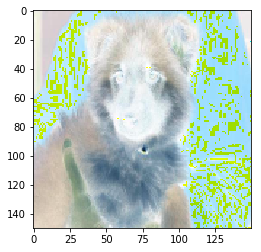

In [22]:
recreate_image_from_numpy_array(x_dev, y_dev, 397)

Label for the below image is 1


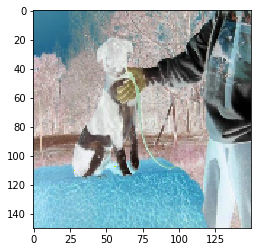

In [23]:
recreate_image_from_numpy_array(x_dev, y_dev, 394)

**Data preprocessing and analysis ends. Deep learning begins!**

**Create placeholders to pass training data when you run the tensorflow session**

In [24]:
def create_placeholders(n_x, n_y, m):
    X = tf.placeholder(name="X", shape=(n_x, None), dtype=tf.float32)
    Y = tf.placeholder(name="Y", shape=(n_y, None), dtype=tf.float32)
    #the below two lines of code will cause problems. 
    #Firstly, there is no freedom in varying number of examples(m).
    #When using minibatches, the last mininbatch size may differ from the rest of the mininbatches
    #Secondly, it will need training and dev sets to consist of same number of examples.
    #X = tf.placeholder(name="X", shape=(n_x, m), dtype=tf.float32)
    #Y = tf.placeholder(name="Y", shape=(n_y, m), dtype=tf.float32)
    
    return X, Y

**Initializes parameters to build a neural network with tensorflow**

**Our architecture will be a follows:**

**Layer 0 : input layer**

**Layer 1(hidden layer): shape of W1 is (125, 67500) and shape of b1 is (125, 1)**

**Layer 2(hidden layer): shape of W2 is (50, 125) and shape of b2 is (50, 1)**

**Layer 3(hidden layer): shape of W3 is (50, 50) and shape of b3 is (50, 1)**

**Layer 4(output layer): shape of W4 is (1, 50) and shape of b4 is (1, 1)**

In [25]:
def initialize_parameters():
    #just so that initialization remains consistent. can be removed.
    #In fact, its better to not use seeding becaus maybe it will lead to a better performance(reach global minimum instead of local minimum).
    tf.set_random_seed(1) 
    W1 = tf.get_variable(name="W1", shape=(125, 67500), 
                         initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable(name="b1", shape=(125, 1), 
                         initializer=tf.zeros_initializer())
    W2 = tf.get_variable(name="W2", shape=(50, 125), 
                         initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable(name="b2", shape=(50, 1), 
                         initializer=tf.zeros_initializer())
    W3 = tf.get_variable(name="W3", shape=(50, 50), 
                         initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable(name="b3", shape=(50, 1), 
                         initializer=tf.zeros_initializer())
    W4 = tf.get_variable(name="W4", shape=(1, 50), 
                         initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b4 = tf.get_variable(name="b4", shape=(1, 1), 
                         initializer=tf.zeros_initializer())
    parameters = {"W1":W1, "b1":b1, "W2":W2, "b2":b2, "W3":W3, "b3":b3, "W4":W4, "b4":b4}
    return parameters

**Implement the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID**

**SIGMOID not implemented here because it is calculated in the cost function**

In [26]:
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    W4 = parameters["W4"]
    b4 = parameters["b4"]
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    A3 = tf.nn.relu(Z3)
    Z4 = tf.add(tf.matmul(W4, A3), b4)
    
    return Z4

**Implement cost function with SIGMOID activation for the last layer**

In [27]:
def compute_cost(Z4, Y, regularize, parameters):
    logits = tf.transpose(Z4)
    labels = tf.transpose(Y)
    lambd = 0.01
    
    if regularize == 'no':
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(name="cost", logits=logits, labels=labels))
    elif regularize == 'yes':
        cost = (tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(name="cost", logits=logits, labels=labels)) +
                lambd*tf.nn.l2_loss(parameters["W1"]) + 
                lambd*tf.nn.l2_loss(parameters["W2"]) + 
                lambd*tf.nn.l2_loss(parameters["W3"]) + 
                lambd*tf.nn.l2_loss(parameters["W4"]))
    return cost

**Function to generate random minibatches of X and Y in synch**

In [28]:
def random_mini_batches(X, Y, mini_batch_size, seed):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for dog / 0 for cat), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    np.random.seed(seed)           
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]
    
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, mini_batch_size*k:mini_batch_size*(k+1)]
        mini_batch_Y = shuffled_Y[:, mini_batch_size*k:mini_batch_size*(k+1)]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, mini_batch_size*num_complete_minibatches:m]
        mini_batch_Y = shuffled_Y[:, mini_batch_size*num_complete_minibatches:m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

**Build the model and run the session!**

In [29]:
def model(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, learning_rate = 0.01, 
          minibatch_size = 64, num_epochs = 250, print_cost = True):
    
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []
    seed = 0
    
    X, Y = create_placeholders(n_x=n_x, n_y=n_y, m=m)
    parameters = initialize_parameters()
    Z4 = forward_propagation(parameters=parameters, X=X)
    cost = compute_cost(Y=Y, Z4=Z4, regularize='no', parameters=parameters)
        
    #optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0.                           # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            for minibatch in minibatches:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch               
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run(fetches=[optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches
            costs.append(epoch_cost)
            if print_cost == True and epoch%10 == 0:
                print("Cost after epoch {} is : {}".format(epoch, epoch_cost))
                
        plt.plot(np.squeeze(costs))
        plt.ylabel("Cost")
        plt.xlabel("Iterations")
        plt.title("Learning rate: {}".format(learning_rate))
        plt.show()
        
        #lets save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")
        
        correct_prediction = tf.equal(x=tf.round(x=tf.sigmoid(Z4)), y=Y)
        accuracy = tf.reduce_mean(tf.cast(x=correct_prediction, dtype="float"))
        
        print("Train accuracy:", accuracy.eval({X:X_train, Y:Y_train}))
        print("Dev set accuracy:", accuracy.eval({X:X_dev, Y:Y_dev}))
        print("Test set accuracy:", accuracy.eval({X:X_test, Y:Y_test}))
        
        return parameters

Instructions for updating:
Use the retry module or similar alternatives.
Cost after epoch 0 is : 0.7086679235748624
Cost after epoch 10 is : 0.6485111104405444
Cost after epoch 20 is : 0.6086624096269194
Cost after epoch 30 is : 0.5638259791809579
Cost after epoch 40 is : 0.5111731537010358
Cost after epoch 50 is : 0.5082115699415622
Cost after epoch 60 is : 0.4661462792883748
Cost after epoch 70 is : 0.38018263325743046
Cost after epoch 80 is : 0.3561522633485172
Cost after epoch 90 is : 0.3308735956316408
Cost after epoch 100 is : 0.34776208663116337
Cost after epoch 110 is : 0.2558945385010346
Cost after epoch 120 is : 0.14160441736812174
Cost after epoch 130 is : 0.28636701194488473
Cost after epoch 140 is : 0.5364659759013549
Cost after epoch 150 is : 0.08496942638379078
Cost after epoch 160 is : 0.06437218865460673
Cost after epoch 170 is : 0.08751033287009467
Cost after epoch 180 is : 0.03533004479401785
Cost after epoch 190 is : 0.07386414777568501
Cost after epoch 200 is : 0.1

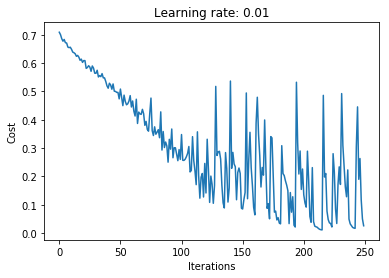

Parameters have been trained!
Train accuracy: 0.9953333
Dev set accuracy: 0.589
Test set accuracy: 0.609


In [30]:
parameters = model(X_train=x_train, Y_train=y_train, X_dev=x_dev, Y_dev=y_dev, X_test=x_test, Y_test=y_test)

**Bear in mind that :**

**1.#hidden layers and  #hidden units in each layer didn't change. Human accuracy considered is ~100% to estimate avoidable bias and variance.**

**2.m_train = #training examples, m_dev = #dev_set examples and m_test = #test set examples. Could not increase them(to reduce overfitting/high variance) across trials as kaggle kernel kept crashing. **

**In brief, the following iterations were carried out**

**Trial #1**

1. m_train=3000

2.m_dev=1000

3.m_test=1000

4.Regularization=no

5.learning_rate=0.01

6.optimizer=Gradient Descent

7.minibatchsize=64

8.Activation=tanh

9.#epoch=200

10.TrainAccuracy=92.83

11.DevAccuracy=57.1

12.TestAccuravy=62.7

13.Comments=Avoidable bias. Try ReLU.

**Trial #2**

1. m_train=3000

2.m_dev=1000

3.m_test=1000

4.Regularization=no

5.learning_rate=0.01

6.optimizer=Gradient Descent

7.minibatchsize=64

8.Activation=ReLU

9.#epoch=200

10.TrainAccuracy=99.93

11.DevAccuracy=60.1

12.TestAccuravy=62.1

13.Comments=High variance. Try regularization.

**Trial #3**

1. m_train=3000

2.m_dev=1000

3.m_test=1000

4.Regularization=L2 ; regularization parameter lambd=0.01

5.learning_rate=0.01

6.optimizer=Gradient Descent

7.minibatchsize=64

8.Activation=ReLU

9.#epoch=200

10.TrainAccuracy=94.17

11.DevAccuracy=59.2

12.TestAccuravy=60.4

13.Comments=No improvement. Try more training data(couldn't). Train longer(avoidable bias surfaced again).

**Trial #4**

1. m_train=3000

2.m_dev=1000

3.m_test=1000

4.Regularization=L2 ; regularization parameter lambd=0.01

5.learning_rate=0.01

6.optimizer=Gradient Descent

7.minibatchsize=64

8.Activation=ReLU

9.#epoch=300

10.TrainAccuracy=99.47

11.DevAccuracy=59

12.TestAccuravy=61.5

13.Comments=Avoidable bias solved. High variance, try Adam optimizer.

**Trial #5**

1. m_train=3000

2.m_dev=1000

3.m_test=1000

4.Regularization=L2 ; regularization parameter lambd=0.01

5.learning_rate=0.001

6.optimizer=Adam

7.minibatchsize=64

8.Activation=ReLU

9.#epoch=300

10.TrainAccuracy=50.6

11.DevAccuracy=47.8

12.TestAccuravy=50.4

13.Comments=Why isn't Adam working? Back to Gradient Descent.

**Trial #6**

1. m_train=3000

2.m_dev=1000

3.m_test=1000

4.Regularization=L2 with different regularization parameters(lambd) for different layers(lambd=0.01 for layer1, lambd =0.001 for layer2, lambd=0.0001 for layer3, lambd=0.00001 for layer4)

5.learning_rate=0.001

6.optimizer=Gradient Descent

7.minibatchsize=64

8.Activation=ReLU

9.#epoch=200

10.TrainAccuracy=93.4

11.DevAccuracy=58.4

12.TestAccuravy=59

13.Comments=Not helping.

**As can be seen, high variance problem is not going away. So, let's stick to the better configuration(Trial #2) for the time being **

**Maybe you could  try experimenting more with these settings and see if the model performs better.  Let me know in the comments! **

**Please upvote if you find this notebook useful**